In [136]:
from cereeberus import ReebGraph, MapperGraph, Interleave
import cereeberus.data.ex_mappergraphs as ex_mg

import matplotlib.pyplot as plt
import numpy as np

In [137]:
# Using PuLP to solve the ILP (Should I use something else?)
import pulp

# Given two mapper graphs and associated matrices, I am trying to see if the problem can be solved using integer linear programming (ILP).

_Note to self: Fill in the ILP details here._

## Let's create two example mapper graphs.

Text(0.5, 1.0, 'T')

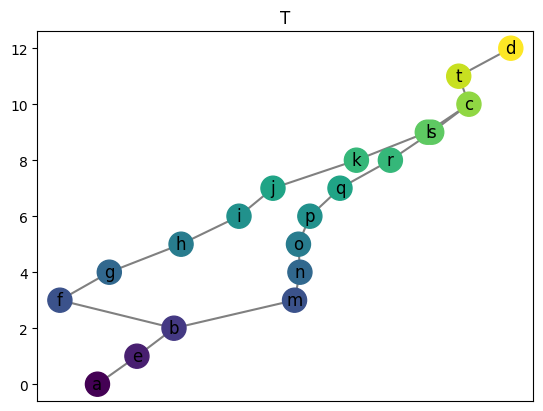

In [138]:
T = ex_mg.torus(0, 2, 10, 12, delta = 1, seed = 17)
T.draw()
plt.title('T')

Text(0.5, 1.0, 'L')

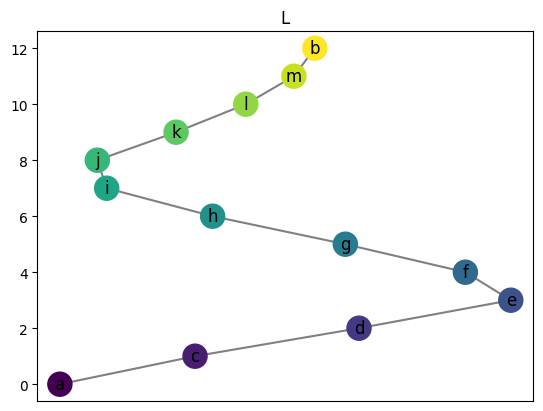

In [139]:
L = ex_mg.line(0, 12)
L.draw()
plt.title('L')

Create an interleaving and to generate all the relevant matrices.

Then, we can try to solve the problem using ILP.

In [140]:
myInt = Interleave(T, L, initialize_random_maps=True, seed=0)

## Let's get all the matrices. Diagram: Vertex triangle F_G_F.

Inclusion matrices to define the maps $F \to F_n \to F_{2n}$ and $G \to G_n \to G_{2n}$. Can be accessed by `Interleave.I`. 

For vertex triangle from $F$ to $G$, we need $I^V_{F^n}$ and $I^V_{F}$

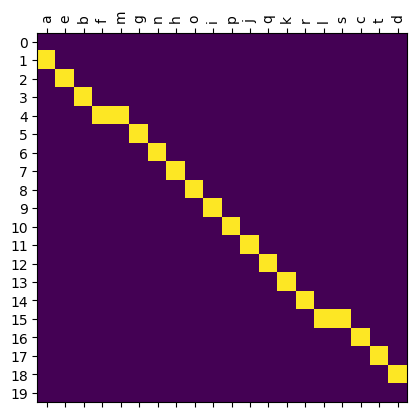

In [141]:
# Inclusion matrices 

I_F_0 = myInt.I('F', '0', 'V')
I_F_0.draw()

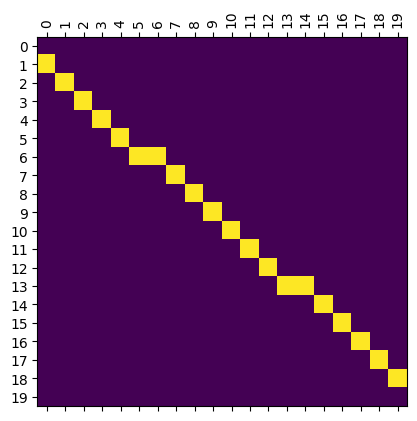

In [142]:
I_F_n = myInt.I('F', 'n', 'V')
I_F_n.draw()

Multiply $I^V_{F^n}$ with $I^V_{F}$ and denote it by $I$. <span style="color:red"> Is the multiplication method  correct? </span>

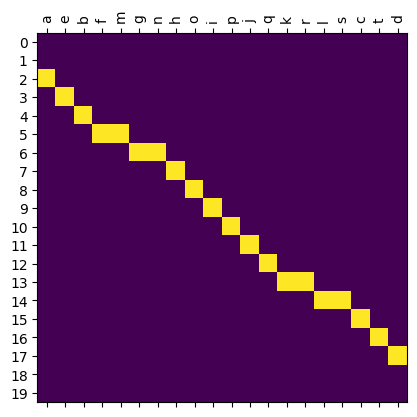

In [143]:
# multiply two matrices
I = I_F_n @ I_F_0
I.draw()

# We also keep a labeled matrix representation of the inclusion matrix
I_mat = I.to_labeled_matrix().get_array()

Store the distance matrix too. We need $D^V_{F^{2n}}$. Can be summoned by `Interleave.D`.

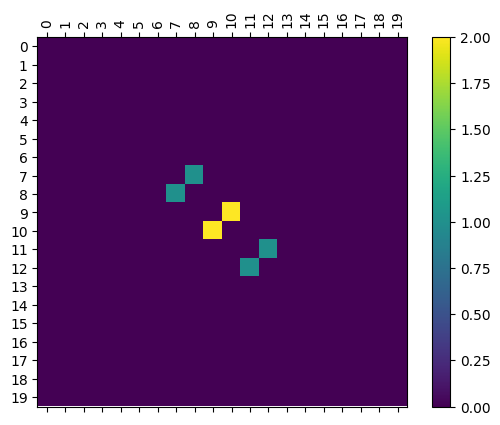

In [144]:
D = myInt.D('F', '2n', 'V')
D.draw(colorbar=True)

# We also keep a labeled matrix representation of the distance matrix
D_mat = D.to_labeled_matrix().get_array()


Let's also store a $\varphi_V$ and $\psi_V^n$ matrices. These two are variable matrices in the ILP. Can be summoned by `Interleave.phi` and `Interleave.psi`.

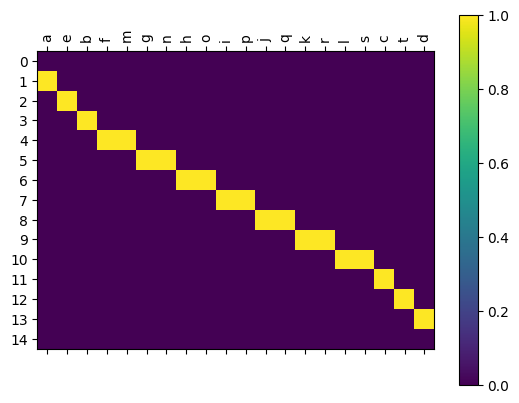

In [145]:
phi = myInt.phi('0', 'V')
phi.draw(colorbar=True)

# We also keep a labeled matrix representation of the phi matrix
phi_mat = phi.to_labeled_matrix().get_array()


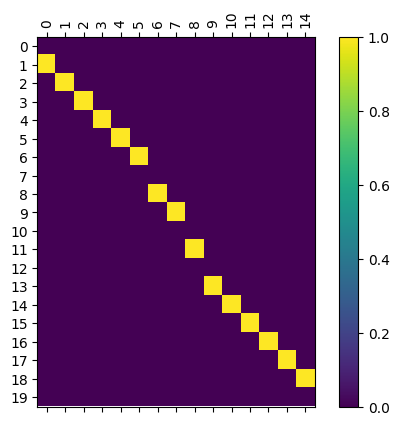

In [146]:
psi_n = myInt.psi('n', 'V')
psi_n.draw(colorbar=True)

# We also keep a labeled matrix representation of the psi matrix
psi_n_mat = psi_n.to_labeled_matrix().get_array()

### Before we set an ILP, let's check the dimension and function values of the matrices. Also, if everything lines up, we will try to solve it by block level.

In [147]:
# Print shapes of the matrices
print(f"Shape of inclusion matrix product I_F_n @ I_F_0: {I.shape()}")
print(f"Shape of distance matrix D: {D.shape()}")
print(f"Shape of phi matrix: {phi.shape()}")
print(f"Shape of psi matrix: {psi_n.shape()}")

Shape of inclusion matrix product I_F_n @ I_F_0: (20, 20)
Shape of distance matrix D: (20, 20)
Shape of phi matrix: (15, 20)
Shape of psi matrix: (20, 15)


In [148]:
# print the function values (block indices) of the matrices
print(f"Function values of inclusion matrix product I_F_n @ I_F_0: {I.get_all_block_indices()}")
print(f"Function values of distance matrix D: {D.get_all_block_indices()}")
print(f"Function values of phi matrix: {phi.get_all_block_indices()}")
print(f"Function values of psi matrix: {psi_n.get_all_block_indices()}")

Function values of inclusion matrix product I_F_n @ I_F_0: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Function values of distance matrix D: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Function values of phi matrix: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Function values of psi matrix: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


## Attempt to set up the ILP.

### Initialize the ILP


In [149]:
prob = pulp.LpProblem("Triangle_ILP", pulp.LpMinimize)

### Matrix Parameters

In [150]:
I = I_mat # Inclusion matrix
D = D_mat # Distance matrix
phi = phi_mat # Phi matrix
psi = psi_n_mat # Psi matrix

### Let's clear up the dimension problem


In [151]:
m = 20 # Number of rows in $\psi_n$
n = 15 # Number of columns in $\phi_n$ or Numbe of rows in $\phi$
p = 20 # Number of columns in $\phi$


### define the decision variables


In [152]:
z = pulp.LpVariable.dicts("z", ((i, j, k) for i in range(m) for j in range(n) for k in range(p)), cat='Binary')
psi_vars = pulp.LpVariable.dicts("psi", ((i, j) for i in range(m) for j in range(n)), lowBound=0, cat='Integer')
phi_vars = pulp.LpVariable.dicts("phi", ((j, k) for j in range(n) for k in range(p)), lowBound=0, cat='Integer')
psi_phi = pulp.LpVariable.dicts("psi_phi", ((i, k) for i in range(m) for k in range(p)), lowBound=0, cat='Integer')
minmax_var = pulp.LpVariable("m", lowBound=0, cat='Continuous')

### Objective function

In [153]:
prob += minmax_var

### Initialize the assignment decision variables


In [154]:
for i in range(n):
    for j in range(p):
            prob += phi_vars[i,j] == phi[i][j]

for j in range(m):
    for k in range(n):
            prob += psi_vars[j,k] == psi[j,k]

### Constraints
1. $m \geq  \sum_{i=1}^{m} d_{ik}(I_{ik}-C_{ik})$ for each $k$. 
2. $-m \leq  \sum_{i=1}^{m} d_{ik}(I_{ik}-C_{ik})$ for each $k$.\
<span style="color:red"> This is probably wrong. Check the other notebook.</span>


In [155]:
for i in range(m):
    prob += minmax_var >= pulp.lpSum(D[i][k] *(I[i][k] - psi_phi[i,k])  for k in range(p))
    prob += -minmax_var <= pulp.lpSum(D[i][k] *(I[i][k] - psi_phi[i,k]) for k in range(p))

### Constraints

$C_{ik} = \sum_{j=1}^{n} z_{ijk}$ for each $i$ and $k$.

In [156]:
for i in range(m):
    for k in range(p):
        prob += psi_phi[i,k] == pulp.lpSum(z[i, j, k] for j in range(n))


### Constraints

1. $z_{ijk} \leq \psi_{ij}$ for each $i$, $j$ and $k$.
2. $z_{ijk} \leq \phi_{jk}$ for each $i$, $j$ and $k$

In [157]:
for i in range(m):
    for j in range(n):
        for k in range(p):
            prob += z[i, j, k] <= psi[i, j] 
            prob += z[i, j, k] <= phi[j, k]

### Constraints

$z_{ijk} \geq \psi_{ij} + \phi_{jk} - 1$ for each $i$, $j$ and $k$.

In [158]:
for i in range(m):
    for j in range(n):
        for k in range(p):
            prob += z[i, j, k] >= psi[i, j] + phi[j, k] - 1

### Constraints

These ones ensure that the $\psi$ and $\phi$ represnent valid assignment. This condition says that the sum of each coulmn should add to 1.

1. $ \sum_{i=1}^{m} \psi_{ij} = 1$ for each $j$.
2. $ \sum_{j=1}^{m} \varphi{jk} = 1$ for each $k$.

In [159]:
for i in range(m):
    prob += pulp.lpSum(psi_vars[i,j] for j in range(n)) == 1   

for j in range(n):
    prob += pulp.lpSum(phi_vars[j,k] for k in range(p)) == 1

### Constraints

These constraints ensure that the $\psi$ and $\phi$ are non-negative.

1. $ \psi_{ij} \geq 0$ for each $i$ and $j$.
2. $ \varphi_{jk} \geq 0$ for each $j$ and $k$.

In [160]:
for i in range(m):
    for j in range(n):
        prob += psi_vars[i,j] >= 0

for j in range(n):
    for k in range(p):
        prob += phi_vars[j,k] >= 0

## Solve the ILP

In [161]:
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ishikaghosh/anaconda3/envs/interleavingenv/lib/python3.13/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/5f/m89pr_zs78n8ffl7t7ndknth0000gn/T/7ba9fb8742ac410e822dc4ad76c31891-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/5f/m89pr_zs78n8ffl7t7ndknth0000gn/T/7ba9fb8742ac410e822dc4ad76c31891-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 19680 COLUMNS
At line 59934 RHS
At line 79610 BOUNDS
At line 86611 ENDATA
Problem MODEL has 19675 rows, 7001 columns and 26252 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.91 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.96   (Wallclock seconds):       1.02



-1

## Output the solution

In [162]:
print(f"Objective value (minimization over the maximum of the absolute values of the matrix) = {pulp.value(prob.objective)}")

Objective value (minimization over the maximum of the absolute values of the matrix) = 2.0


Put all the optimized values of the phi and psi matrix back to  matrix form and output it.

In [163]:
Psi_n = np.zeros((m, n))
Phi = np.zeros((n, p))

for i in range(m):
    for j in range(n):
        Psi_n[i,j] = pulp.value(psi_vars[i,j])

for j in range(n):
    for k in range(p):
        Phi[j,k] = pulp.value(phi_vars[j,k])

print(f"Psi_n = {Psi_n}")
print(f"Phi = {Phi}")


Psi_n = [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Phi = [[0. 0. 0. 0. 0. 0. 0. 0.

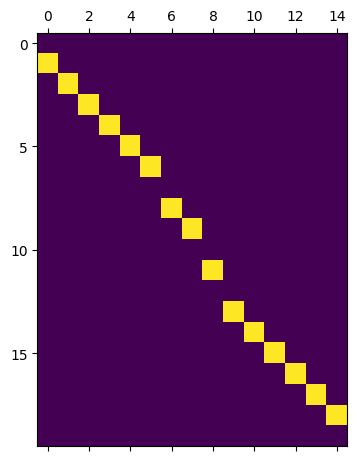

In [164]:
plt.matshow(Psi_n)

As the initial matrices are not equal to final matrices, we can say that ILP is at least doing something.

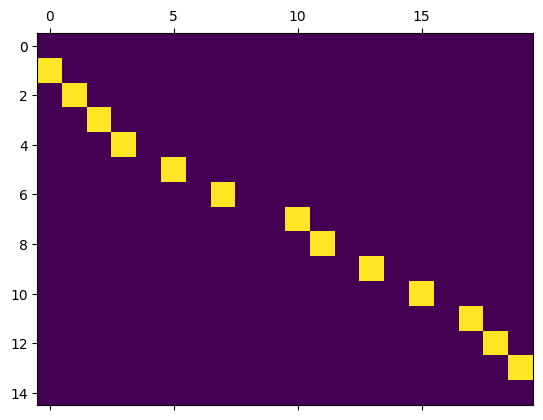

In [165]:
plt.matshow(Phi)

In [166]:
# did phi and psi_n change?
np.allclose(phi_mat, Phi), np.allclose(psi_n_mat, Psi_n)

(False, True)

In [167]:
# do columns add up to 1 for phi and pshi_n?
np.sum(Phi, axis=0), np.sum(Psi_n, axis=0)

(array([1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
        1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))